<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2022_hands_on/blob/main/Week08_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 08

## Introduction

In this notebook we are going to learn about:

*   transfer learning

So far we have learned how to build and train deep neural network models from scratch. Transfer learning is a technique to shortcut some of these processes. Starting point of the transfer learning is a model already trained with other dataset. Such model is called a ***pretrained model***. Then the pretrained model will be trained with a new dataset. In some cases, only a part of parameters (weights and biases) in the pretrained model will be retrained while rest of them are fixed as pretrained. By employing the transfer learning, the model can reach higher performance with less training time compared with training it from scratch. 

### GPU

Please make sure your runtime type is GPU (cuda).

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

### No GPU?

If you have been using GPU for many hours, you may get this message. Then you are not allowed to use GPU for a while - depending on other users' usage.

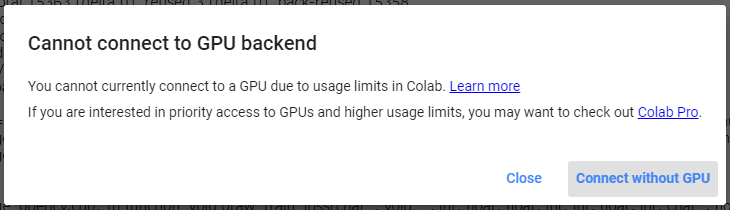

Google offers you a paid-option "Colab Pro". But you don't have to pay just for this lecture. You can still use GPU for free just by using another google account.

### General Packages

Let's import some general Python packages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import gdown

## Data Preparation

### CIFA10 Dataset

We are going to use CIFAR10 dataset again. Here we change the image size from 32x32 to 96x96, and also apply the data standadization.

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

img_size = (96, 96)
means = (0.49, 0.48, 0.45)
stds = (0.25, 0.24, 0.26)

train_dataset = CIFAR10(root="cifar10", train=True, download=True, 
                        transform=transforms.Compose([
                            transforms.Resize(img_size),
                            transforms.ToTensor(),               # convert to torch.tensor
                            transforms.Normalize(means, stds),   # standardization
                            ])
                   )
                   
test_dataset = CIFAR10(root="cifar10", train=False, download=True,
                        transform=transforms.Compose([
                            transforms.Resize(img_size),
                            transforms.ToTensor(),                # convert to torch.tensor
                            transforms.Normalize(means, stds),    # standardization
                            ])
                   )

classnames_cifar10 = {0:"plane", 1:"car", 2:"bird", 3:"cat", 4:"deer",
                      5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

### DataLoader

Then we create `DataLoader`s for feeding data to the model. This is exactly same as we did before.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

## Model

### Load Pretrained Model

Now we load a pretrained model from `torchvison.models`. We will use a model called VGG16 which is one of the well-known image classification models. By specifying `vgg16(pretrained=True)`, we can load the VGG16 model pretrained with the dataset called ImageNet. ImageNet dataset consists of more than 1.2 million images with 1000 categories.

VGG16 https://arxiv.org/abs/1409.1556

ImageNet Dataset https://www.image-net.org/update-mar-11-2021.php


In [ ]:
import torchvision.models as models

model = models.vgg16(pretrained=True)
print(model)

The VGG16 model consists of the features and the classifier parts. The features part are made of several Conv2d and MaxPool2d layers, and the classifier parts are made of several Linear layers.

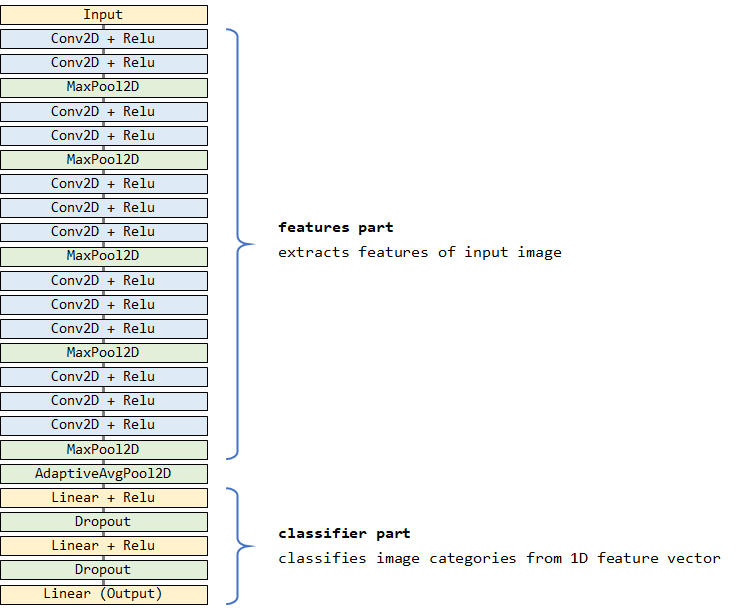

### Use Pretrained Model
In fact, we can use the pretrained VGG16 model as downloaded. So let's try this first.

By executing the code below, a sample image data` elephant.jpg` and a classname text data `imagenet1000_clsidx_to_labels.txt` will be downloaded.

In [ ]:
gdown.download('https://drive.google.com/uc?id=1xcRoRUA7ZyEVxXJqKz-44_eojr67X0ca', 'elephant.jpg', quiet = False)
gdown.download('https://drive.google.com/uc?id=1USjiVVoR_6dYOzSwiqAPH41p7psp1pT0', 'imagenet1000_clsidx_to_labels.txt', quiet = False)

Let's take a look at `elephant.jpg`.

In [ ]:
from PIL import Image
img = Image.open("elephant.jpg")
plt.imshow(img)

Let's take a look at `imagenet1000_clsidx_to_labels.txt`.

In [ ]:
import ast
f = open('imagenet1000_clsidx_to_labels.txt')
data = f.read()
classnames_imagenet = ast.literal_eval(data)
classnames_imagenet

 Here we define a function named `preprocess()` to convert an image data to a torch.tensor data so that the model can handle it.

In [ ]:
normalize = transforms.Normalize(means, stds)

def preprocess(img):
    x = img.resize((96, 96))
    x = np.array(x)/255
    x = x.transpose((2, 0, 1))
    x = torch.tensor(x, dtype=torch.float32)
    x = normalize(x)
    x = x.to(device)
    x = x[None, ...]
    return x

Now we can make a prediction for the image data by using the pretrained VGG16 model.

In [ ]:
import torch.nn as nn
softmax = nn.Softmax(dim=0)

with torch.no_grad():
    model.eval()
    model = model.to(device)
    
    img = Image.open("elephant.jpg")
    x = preprocess(img)
    y = model(x)[0]
    probs = softmax(y)
    idx = torch.argmax(probs).item()
    probability = probs[idx].item()
    prediction = classnames_imagenet[idx]

print(f"Prediction Index: {idx}")
print(f"Prediction Label: {prediction}")
print(f"Probability: {probability:.2%}")

### Replace Last Layer
The number of output neurons, i.e. out_features, of the pretrained VGG16 model is 1000. This is because this model is designed for classifying 1000 categories of images.

In [ ]:
model.classifier[6]

Since we are going to classify CIFAR10 dataset, the number of output neurons needs to be 10. Therefore we have to replace the last layer.

In [ ]:
model.classifier[6] = nn.Linear(4096, 10)   # replace the last layer
print(model)

### torchinfo
Let's see how the data shape changes in the model.

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

### Freeze Parameters
The pretrained VGG16 model is well-trained with the ImageNet dataset, therefore the model parapeters (weights and biases) are already good for general image classification tasks. In such case, it might be better to keep (freeze) most of the parameters in the model and re-train only a few layers of the model with the new dataset.

In order to do so, we make all of the parameters in the model to be frozen by setting `requires_grad=False`.

In [ ]:
for param in model.parameters():
    param.requires_grad = False

Then we set `requires_grad=Ture` to some specific layers so that they will be trained.

For example if we want to train only the parameters in the last layer (`model.classfier[6]`, 6th layer in the classifier part), we can do

In [ ]:
model.classifier[6].weight.requires_grad = True
model.classifier[6].bias.requires_grad = True

If we want to train other layers, we can do like

In [ ]:
# 0th layer in the classifier part
model.classifier[0].weight.requires_grad = True 
model.classifier[0].bias.requires_grad = True

# 3rd layer in the classifier part
model.classifier[3].weight.requires_grad = True
model.classifier[3].bias.requires_grad = True

## Training

Traning process is same as we did before.

### Loss Function


In [ ]:
loss_func = nn.CrossEntropyLoss()

### Optimizer


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### Training Loop







In [ ]:
model = models.vgg16(pretrained=True)            # load pretrained model
model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

for param in model.parameters():                 # freeze all parameters
    param.requires_grad = False

model.classifier[6].weight.requires_grad = True  # enable training for the last layer
model.classifier[6].bias.requires_grad = True

model = model.to(device)                         # load model on GPU

loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer
epochs = 3
best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count.item()/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path}")
        best_accuracy = test_accuracy

### Learning Curves

In [ ]:
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

In [ ]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Evaluation

### Load the Best Model

In [ ]:
model = models.vgg16(pretrained=False)              # initialize VGG16 model
model.classifier[6] = nn.Linear(4096, 10)          # replace the last Linear layer
model = model.to(device)                           # load model on GPU
model.load_state_dict(torch.load(best_model_path)) # load the best parameters to the model

### Test Accuracy

In [ ]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode
    
    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

### Confusion Matrix

Then let's check the confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,8))
labels = classnames_cifar10.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=labels, yticklabels=labels, square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

### Predictions for Test Data

Let's see predictions for some test data.

In [ ]:
plt.figure(figsize=(20, 14))

for i in range(50):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))

    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    plt.subplot(5, 10, i+1)
    plt.imshow(image)

    true_class = classnames_cifar10[y_test_all[i]]
    pred_class = classnames_cifar10[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")

### What If Without Pretrained Parameters?
If we want to use VGG16 model without pretrained parameters, i.e. if we want to train VGG16 model from scratch, we can specify `vgg16(pretrained=False)` and train it as usual without freezing parameters. 

In [ ]:
model = models.vgg16(pretrained=False)           # initialize VGG16 model without pretrained parameters
model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

model = model.to(device)                         # load model on GPU

loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer
epochs = 10
best_model_path_from_scratch = 'best_model_from_scratch.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path_from_scratch)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path_from_scratch}")
        best_accuracy = test_accuracy

In [ ]:
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

In [ ]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Conclusion

We used pretrained VGG16 model to demonstrate transfer learning, but many different pretrained models are available in `torchvision.models`. Please refer the link below and try to use some other models.

https://pytorch.org/vision/stable/models.html